In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel
from utils import *
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt

## Load data

In [2]:
import rasterio
from torch.utils.data.dataset import Dataset

class PatchDataset(Dataset):
    def __init__(self, naip_paths_list, label_paths_list, patch_size, mapping=None, transforms=None):
        '''
        Args:
            naip_paths_list (list): Paths to NAIP images
            label_paths_list (list): Paths to labels
            patch_size (tuple): Extracted patch size
            mapping (numpy.array): Label mapping array
            transforms (function): Function that applies image and label transforms
        '''
        self.naip_paths_list = naip_paths_list
        self.label_paths_list = label_paths_list
        self.patch_size = patch_size
        self.mapping = mapping
        if transforms is None:
            self.transforms = lambda x: x
        else:
            self.transforms = transforms

        # Load tiles
        self.naip = []
        for path in self.naip_paths_list:
            with rasterio.open(path) as f:
                self.naip.append(f.read())
        print('Loaded', len(self.naip), 'NAIP tiles')

        self.labels = []
        for path in self.label_paths_list:
            with rasterio.open(path) as f:
                # Apply label mapping
                label_raster = f.read()
                label_raster = self.mapping[label_raster.astype(np.uint8)]
                self.labels.append(label_raster)
        print('Loaded', len(self.labels), 'label tiles')

    def __len__(self):
        assert len(self.naip_paths_list) == len(self.label_paths_list), 'NAIP/Labels tiles mismatch'
        return len(self.naip_paths_list)

    def __getitem__(self, idx):
        '''
        Args:
            idx (int): Index of tile to sample from
        '''
        # Select the tile to get a random patch from
        naip = self.naip[idx]
        labels = self.labels[idx]
        
        # Randomly select patch in tile
        height, width = naip.shape[1], naip.shape[2]
        row = torch.randint(0, height - self.patch_size[0], size=(1,)).item()
        col = torch.randint(0, width - self.patch_size[1], size=(1,)).item()

        # Use copy to not modify the original labels
        naip_patch = naip[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()
        labels_patch = labels[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()
        
        # Apply transforms
        naip_patch = torch.from_numpy(naip_patch)
        labels_patch = torch.from_numpy(labels_patch)
        naip_patch, labels_patch = self.transforms(naip_patch, labels_patch)
        
        return {'naip': naip_patch, 'labels': labels_patch}
    

In [5]:
# Specify tiles
naip_paths = glob.glob('data/enviroatlas_lotp/pittsburgh_pa-2010_1m-train_tiles-debuffered/*naip.tif')
naip_paths.sort()
label_paths = glob.glob('data/enviroatlas_lotp/pittsburgh_pa-2010_1m-train_tiles-debuffered/*highres_labels*.tif')
label_paths.sort()

# Transforms to apply
def transforms(img, labels, p_horizontal=0.5, p_vertical=0.5):
    # Horizontal flip
    p = np.random.rand()
    if p < p_horizontal:
        img = torchvision.transforms.functional.hflip(img)
        labels = torchvision.transforms.functional.hflip(labels)
        
    # Vertical flip
    p = np.random.rand()
    if p < p_vertical:
        img = torchvision.transforms.functional.vflip(img)
        labels = torchvision.transforms.functional.vflip(labels)
        
    # Resizing
    img = F.interpolate(img.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0) / 255.
    labels = F.interpolate(labels.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)

    return img, labels
    
# Create data set
device = torch.device('cuda:0')
patch_size = (256,256)
n_labels = len(enviroatlas_simplified_labels)
dataset = PatchDataset(naip_paths, label_paths,
                       patch_size=patch_size, 
                       mapping=enviroatlas_simplified_label_mapping_array,
                       transforms=transforms)

# Create random patch-sampling dataloader
batch_size = 32
sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=sampler)
print('Created dataset')

Loaded 10 NAIP tiles
Loaded 10 label tiles
Created dataset


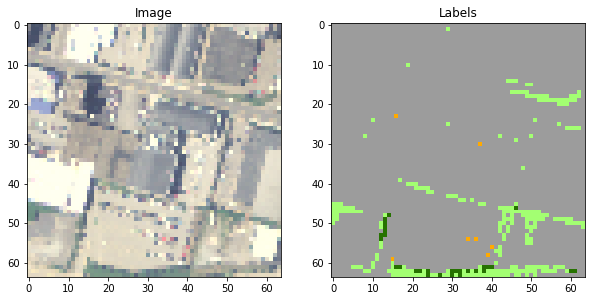

In [7]:
# Sample random batch
for batch in dataloader:
    naip = batch['naip']
    labels = batch['labels']
    labels_one_hot = F.one_hot(labels.long(), n_labels).transpose(-1,1).squeeze(-1).float()
    break
    
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(naip[0].numpy().transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels[0,0,:,:], cmap=enviroatlas_simplified_cmap, vmin=0, vmax=n_labels-1, interpolation='none')
ax[1].set_title('Labels')
plt.show()

## Train Model

In [ ]:
# Train diffusion model
diffusion = GaussianDiffusion(T=1000, schedule='linear')
net = UNetModel(image_size=patch_size[0], in_channels=n_labels, out_channels=n_labels, 
                model_channels=128, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[16,8], num_heads=4).to(device)
print('Parameters:', sum([p.numel() for p in net.parameters()]))
net.train()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

steps = 100000
update_every = 20
vis_every = 10000
save_every = 10000
losses = []
progress_bar = tqdm.tqdm(range(steps))
    
for i in progress_bar:
    for batch in dataloader:
        # Unwrap batch
        naip = batch['naip']
        labels = batch['labels']
        labels = F.one_hot(labels.long(), n_labels).transpose(-1,1).squeeze(-1).float()
        
    # Sample from diffusion
    t = np.random.randint(1, diffusion.T+1, labels.shape[0]).astype(int)
    xt, epsilon = diffusion.sample(labels, t)
    t = torch.from_numpy(t).float().view(labels.shape[0])
    # Denoise
    epsilon_pred = net(xt.float().to(device), t.float().to(device))

    # Compute loss   
    loss = F.mse_loss(epsilon_pred, epsilon.float().to(device))
    # Update parameters
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    if (i+1) % update_every == 0 or i == 0:
        progress_bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % vis_every == 0:
        with torch.no_grad():
            net.eval()
            sample = diffusion.inverse(net, shape=(n_labels,64,64))
            net.train()

        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        ax.imshow(labels_to_color(sample[0].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
        ax.set_title('Sample')
        plt.show()

    # Save model parameters
    if (i+1) % save_every == 0:
        torch.save(net.state_dict(), f'models/unet_{i+1}.pth')

torch.save(net.state_dict(), f'models/unet_{i+1}.pth')
    

## Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


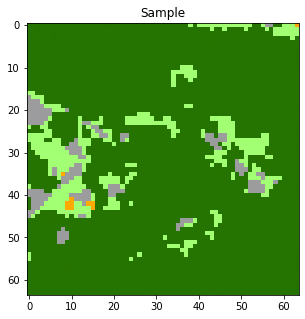

In [10]:
diffusion = GaussianDiffusion(T=1000, schedule='linear')

with torch.no_grad():
    net.eval()
    sample = diffusion.inverse(net, shape=(n_labels,patch_size[0]//4,patch_size[1]//4), device=device)
    net.train()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(labels_to_color(sample[0].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax.set_title('Sample')
plt.show()

## Save/Load Model

In [9]:
# Save/Load model
#torch.save(net.state_dict(), f'models/unet_final.pth')
 
net = UNetModel(image_size=patch_size[0], in_channels=n_labels, out_channels=n_labels, 
                model_channels=128, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[16,8], num_heads=4).to(device)

net.train()
net.load_state_dict(torch.load('models/unet_100000.pth'))

<All keys matched successfully>